# Support Vector Machine 

In [42]:
# General Import
import glob
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import gzip, pickle, pickletools
from sklearn.svm import SVC
from PIL import Image

In [44]:
# Downloading Data
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  263M  100  263M    0     0  19.8M      0  0:00:13  0:00:13 --:--:-- 23.7M


In [4]:
!unzip -q GTSRB_Final_Training_Images.zip

In [9]:
TRAINING_CSV_PATH = './GTSRB/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30
IMAGE_HEIGHT = IMAGE_WIDTH

In [10]:
os.path.dirname(TRAINING_CSV_PATH)

'./GTSRB/Final_Training/Images/*'

In [11]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        image = image.flatten()
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values

In [12]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,81,82,7,8,74,75,39,./GTSRB/Final_Training/Images/00039/00000_0000...
1,00000_00001.ppm,81,81,7,7,74,74,39,./GTSRB/Final_Training/Images/00039/00000_0000...
2,00000_00002.ppm,82,81,8,7,75,74,39,./GTSRB/Final_Training/Images/00039/00000_0000...
3,00000_00003.ppm,83,82,7,7,75,75,39,./GTSRB/Final_Training/Images/00039/00000_0000...
4,00000_00004.ppm,85,85,8,8,78,78,39,./GTSRB/Final_Training/Images/00039/00000_0000...


In [14]:
N = 10_000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 2700) (39209,)


In [16]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 2700) (7842, 2700) (31367,) (7842,)


### Trainning our SVM

In [21]:
svclassifier = SVC(C=1, kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
# Saving Model
filepath = "svm_model.pkl"
with gzip.open(filepath, "wb") as f:
  pickled = pickle.dumps(svclassifier)
  optimized_pickle = pickletools.optimize(pickled)
  f.write(optimized_pickle)

### Testing the model

In [30]:
# Load the model
with gzip.open(filepath, 'rb') as f:
  p = pickle.Unpickler(f)
  loaded_model = p.load()

In [25]:
def classify_image(path, model, image_box=None):
  """Classify image by model

  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier

  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  image = image.flatten()
  images_list.append(image)
  
  return model.predict(np.array(images_list))

In [26]:
image_sample = images_df.sample(1)

classify_image(image_sample['path'].values[0],
               loaded_model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

array([15])

In [31]:
loaded_model.score(X_test, y_test)

0.9711808212190768

In [ ]:
# Saving the model
import pickle
filename = 'pickle_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [35]:
!unzip -q GTSRB_Final_Test_Images.zip

In [32]:
!unzip GTSRB_Final_Test_GT.zip

Archive:  GTSRB_Final_Test_GT.zip
  inflating: GT-final_test.csv       


In [33]:
test_images_df = pd.read_csv('GT-final_test.csv', sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: './GTSRB/Final_Test/Images/' + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,./GTSRB/Final_Test/Images/12625.ppm
12626,12626.ppm,50,51,6,5,45,46,33,./GTSRB/Final_Test/Images/12626.ppm
12627,12627.ppm,29,29,6,6,24,24,6,./GTSRB/Final_Test/Images/12627.ppm
12628,12628.ppm,48,49,5,6,43,44,7,./GTSRB/Final_Test/Images/12628.ppm
12629,12629.ppm,32,31,6,5,27,26,10,./GTSRB/Final_Test/Images/12629.ppm


In [36]:
test_list = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)

In [37]:
results = loaded_model.predict(test_data)

In [38]:
(test_labels == results).sum() / test_labels.shape[0]

0.8735550277117973

In [39]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

In [40]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


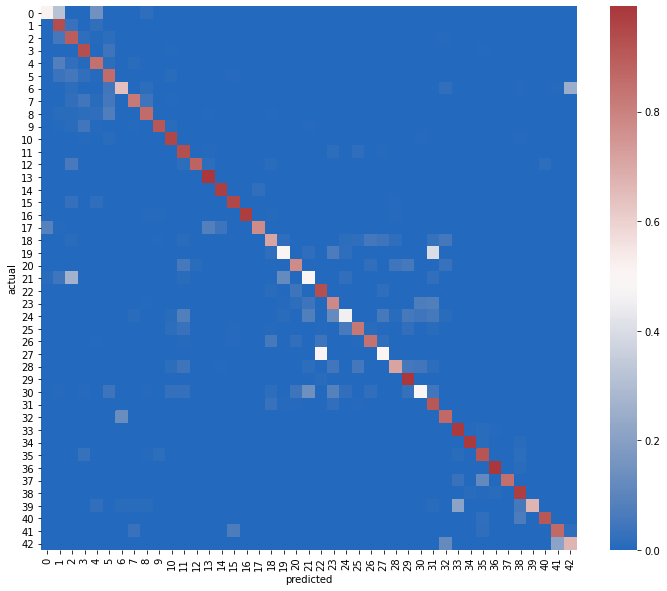

In [43]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);

**Les resultats du SVM sont moins bien que le reseau de neurone profond. Ce qui est conforme a ce qu'on pourrait s'attendre**